# Notebook 6: Representation challenge in ML
This notebook consist of two parts. The first part contains an example of a Machine Learning Force Field (MLFF) on a $C_{60}$ buckyball molecule. The second part contains a starting exercise for of the 5EC project.

# Part 1: Learning the potential energy surface of a thermally distorted buckyball 

We want to capture the **state** of the system by an efficient set of features. Preferably, the state should be unique. In this way one input state can be linked to only one label.

We will now consider the case of a single buckyball molecule. The coordinates of the atomic nuclei describe the structural arrangement $\{\mathbf{R}^{(m)}_i\}$ and total potential energy $(U_m)$ of the molecule as a whole. 

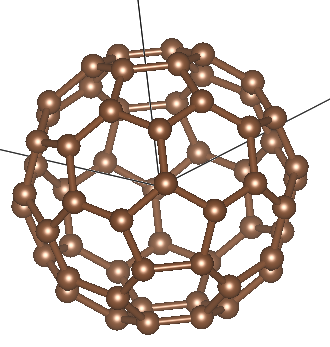

In [3]:
# importing the required modules
##%pip install numpy matplotlib scikit-learn pandas #installs them if they are not yet there
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

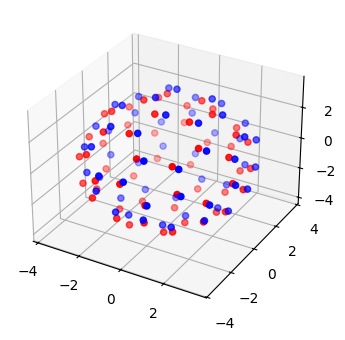

In [4]:
# Load the structural and energy database for the buckyballs
Msample=25
coords_data_tmp=(np.loadtxt('bucky-coords_database.txt'))
coords_data=np.zeros((60,3,Msample))
for i in range(Msample):
    coords_data[:,:,i]=coords_data_tmp[i*60:(i+1)*60,0:3]

energy_data=np.loadtxt('bucky-energies_database.txt')
energy_data=energy_data.reshape((Msample,1))

# Plot the first and last structure in the database
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(coords_data[:,0,0],coords_data[:,1,0],coords_data[:,2,0],c='b', marker='o')
ax.scatter(coords_data[:,0,Msample-1],coords_data[:,1,Msample-1],coords_data[:,2,Msample-1],c='r', marker='o')


## ML model of the potential energy surface
We now want to use ML to learn the map from coordinates to potential energy $F_{ML}[\mathbf{R_1},\cdots,\mathbf{R}_{60}]$, however Cartesian coordinates are not very suitable. Given a set of Cartesian coordinates of molecule m ($\{\mathbf{R}^{(m)}_i\}$) we can translate and rotate the molecule in space without changing its potential energy. This means that there are **infinitely** many Cartesian state representations for exactly the same molecule.

**Minimal solution to be implemented:**
1. Represent each atom in the molecule by the three distances to the nearest neighboring atoms $[d_{nn1},d_{nn2},d_{nn3}]$. This does not reduce the dimensionality of our representation, ie. coords[60,3] to new_coords[60,3], but in this representation the molecule is **invariant to translation and rotation**. This representation is called a **descriptor**. _Does it matter how you order the distances, ie. $[d_{nn2},d_{nn3},d_{nn1}]$ or any other permutation?_
2. We furthermore assume that the potential energy of the whole molecule can be descomposed into local atomic energies: $U^{(m)}=\sum_{i=1}^{60}U_i=\sum_{i=1}^{60}F_{ML}[d_{nn1},d_{nn2},d_{nn3}]$.
3. Build a ML model that maps the descriptor to the energy label. This can be a regression model or a small neural network, you choose, you set it up and make it work.

**Optional improvements:**
You might not be satisfied with the RMS error that your ML model scores on the training set. That is to be expected as you have thrown a lot of information about the buckyball out of the window by respesnting it only by its nearest neighbor distances. These improvemets might improve the accuracy of your model and could imporve the predictions your make on the test set.

4. Extend the representation of the atoms with the angles that it makes with the nearest neighboring atoms $[d_{nn1},d_{nn2},d_{nn3}, \theta_1, \theta_2, \theta_3]$.
5. Extend the representation to the second nearest neighboring atoms.



In [5]:
# Helper routine, use if you find it usefull.
# Sets up a nearest neighbor table in which you find all atoms within a distance < 1.5 Angstrom.
# nn (i: atom index , j : index of the neigbouring atom , (0): index number of neigbour (1) distance to that neighbor )
def nntable(coords,maxnn=3,cutoff=1.5):
    N=coords.shape[0]
    nn=np.zeros((N,maxnn,2))
    cnt=0
    maxcnt=0
    for i in range(0,N):
        for j in range(0,N):
            if i!=j: 
                dist=np.linalg.norm(coords[i,:]-coords[j,:])
                #print(dist)
                if dist<cutoff:
                    nn[i,cnt,0]=j
                    nn[i,cnt,1]=dist
                    cnt=cnt+1
                    if cnt>maxcnt:
                        maxcnt=cnt
                    ##print(nn)
        cnt=0
    #print(maxcnt)
    return(nn)

have_a_look_athis =nntable(coords_data[:,:,0],maxnn=3,cutoff=1.6)

#int()
#have_a_look_athis[:,:,0]

In [6]:
# 1. Build the descriptor. Your function should read in all coordinates of one molecule coord[60,3] and give back a descriptor [60,3] with the distances to the closest nearest neighbors.
# nn (i: atom index , j : index of the neigbouring atom , (0): index number of neigbour (1) distance to that neighbor )

def descriptor(coords, 
               nn=nntable(coords_data[:,:,0],maxnn=3,cutoff=1.6),
                maxnn=3):

    N=coords.shape[0]
    desc = np.zeros((N,maxnn))
    
    for i in range(N):
        for j in range(maxnn):
            desc[i,j]= np.linalg.norm(coords[i,:]-coords[int(nn[i,j,0]),:])

    desc = np.sort(desc,axis=1)
    
    return desc

desc = descriptor(coords_data[:,:,2])
desc

array([[1.39981821, 1.44203618, 1.46988772],
       [1.35755807, 1.40206182, 1.48124274],
       [1.40875419, 1.42254319, 1.48376773],
       [1.39882491, 1.44419413, 1.44468846],
       [1.37657571, 1.40236991, 1.45869348],
       [1.38699949, 1.41493541, 1.44781176],
       [1.39981821, 1.44728645, 1.45579949],
       [1.35755807, 1.42633938, 1.46373866],
       [1.40875419, 1.41172679, 1.44903021],
       [1.39882491, 1.42106672, 1.45252303],
       [1.40236991, 1.40242438, 1.43674596],
       [1.38699949, 1.45484609, 1.47196016],
       [1.41576559, 1.44203618, 1.45847303],
       [1.39601503, 1.40206182, 1.41727273],
       [1.41783324, 1.42254319, 1.42559029],
       [1.41468975, 1.41884628, 1.44419413],
       [1.37657571, 1.39119904, 1.48003545],
       [1.41493541, 1.42329835, 1.44957585],
       [1.35350178, 1.44242219, 1.45579949],
       [1.39380823, 1.45102239, 1.46373866],
       [1.38192444, 1.41172679, 1.49765996],
       [1.41967432, 1.45252303, 1.45976794],
       [1.

In [7]:
# 2 & 3 Build your ML model to learn the potential energy of a buckyball based on its atomic coordinates.
# You can build a Rgression model or a NN. Do not forget to feature scale!
    
def compute_descriptors(coords_data,Msample, maxnn=3, cutoff=1.6):
    
    descriptors = []
    
    for i in range(Msample):
        
        nn_table = nntable(coords_data[:, :, i], maxnn=maxnn,cutoff=cutoff)
        d = descriptor(coords_data[:, :, i], nn=nn_table, maxnn=maxnn) 
        ##descriptors.append(descriptor(coords_data[:,:,i]))
        descriptors.append(d)
    
    return descriptors

descriptors = compute_descriptors(coords_data,Msample)
##descriptors

In [8]:
maxnn=3
X = np.zeros((Msample, maxnn))

for i in range(Msample):
    X[i, :] = np.sum(descriptors[i], axis=0)

In [9]:
from sklearn.preprocessing import StandardScaler

##X = compute_descriptors(coords_data,Msample) 
y = energy_data 

print("X",X.shape,"Y",y.shape)

np.random.seed(42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X (25, 3) Y (25, 1)


In [10]:
## Linear Regression
# from sklearn.linear_model import LinearRegression#, Ridge, Lasso

# reg = LinearRegression() 
# reg.fit(X_train_scaled, y_train)

In [11]:
## Polynomial R
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_scaled)#.reshape(-1, 1))

from sklearn.linear_model import LinearRegression
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_pred = poly_reg_model.predict(poly_features)

In [20]:
# # Ridge
# from sklearn.linear_model import LinearRegression, Ridge, Lasso

# reg = LinearRegression() 
# reg.fit(X_scaled, y)

# ridge = Ridge(alpha=0.0001)
# ridge.fit(poly_features, y)

## Analyse the accuracy of your ML model on the training set

RMSerror: 0.0359528531608419


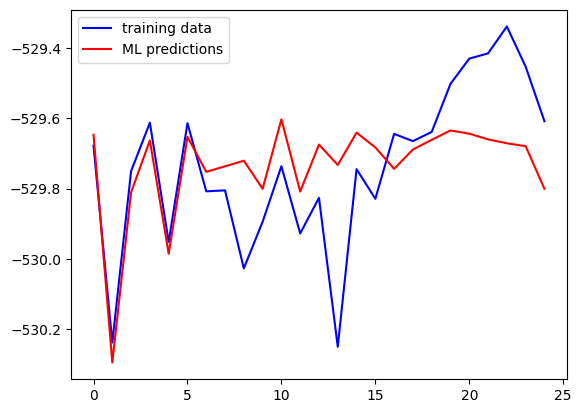

In [12]:
ypred = poly_reg_model.predict(poly_features)
error=ypred-y
rmserror=np.linalg.norm(error)*(1/Msample)
print('RMSerror:',rmserror)
plt.plot(y,color='b',label='training data')
plt.plot(ypred,color='r',label='ML predictions')
plt.legend()


## Use your ML model to predict energies on the test set

[[83.91801198 86.39651555 88.40689455]
 [84.32535981 86.48831242 87.98232461]
 [84.01889049 86.23853816 88.10107056]
 [83.90166496 86.61359527 87.86222478]
 [83.92040132 86.4063149  88.48485194]
 [83.82104869 86.58248195 88.51931663]
 [83.47903234 86.44074443 88.50283664]
 [83.4339907  86.58561466 88.51144428]
 [83.88930502 86.55473048 88.48792251]
 [83.88043749 86.39496942 88.12418449]
 [83.92226843 86.28572628 88.07686405]
 [84.20569349 86.51090346 88.20319904]
 [84.19123212 86.19705671 88.16947813]
 [83.76877647 86.48347284 88.0754491 ]
 [83.76478711 86.48956301 88.6838824 ]
 [83.57869709 86.5528906  88.74763159]
 [83.28563983 86.64882428 88.60744296]
 [83.58131039 86.51021519 88.52985433]
 [83.88147961 86.51368103 88.47187894]
 [84.12671467 86.19997128 88.14296249]
 [84.00627029 86.32205434 88.0527627 ]
 [84.24102722 86.43158047 88.23783849]
 [83.97829764 86.41078245 88.35116074]
 [83.66509021 86.4186025  88.21871886]
 [83.73173215 86.67150577 88.47910581]]
[[-529.65828762]
 [-529.

C:\Users\Mardeen\AppData\Local\Temp\ipykernel_13684\420179678.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


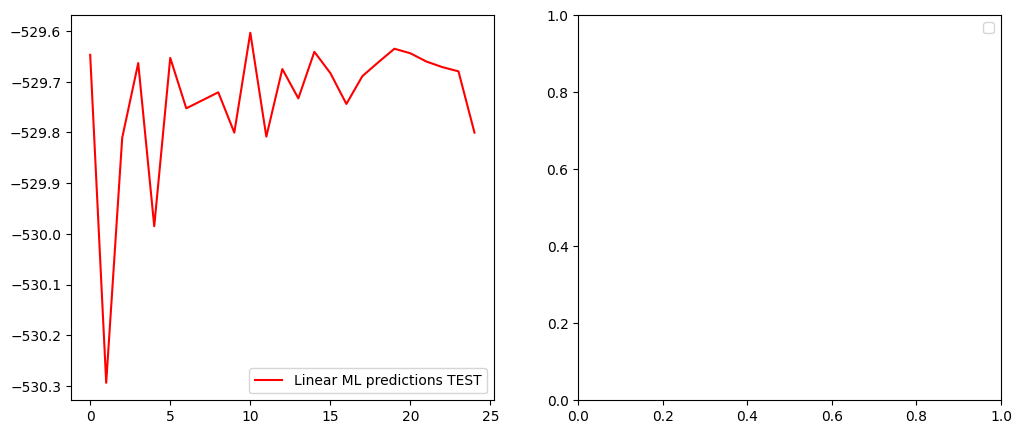

In [ ]:
# Load the TEST structural database for the buckyballs   
Msample=25
coords_data_tmp=np.loadtxt('TESTbucky-coords_database.txt')
coords_data_test=np.zeros((60,3,Msample))
for i in range(Msample):
    coords_data_test[:,:,i]=coords_data_tmp[i*60:(i+1)*60,0:3]
    
#print(coords_data_test) 

########
descriptors_test = compute_descriptors(coords_data_test,Msample)

X_test = np.zeros((Msample, maxnn))
for i in range(Msample):
    X_test[i, :] = np.sum(descriptors_test[i], axis=0)

print(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)
y_pred = poly_reg_model.predict(X_test_poly)

print(y_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ypred,color='r',label='Linear ML predictions TEST')
ax[1].plot(ypred_poly,color='g',label='Quadratic ML predictions TEST')
ax[0].legend()
ax[1].legend()

np.savetxt('PREDICTIONS-energies_TEST.txt', ypred)

# Part 2: Representation of the game broad in DiceWars 

In the final assignment of this year you have to describe the **state** of the DiceWars game board. In this last part of the representation notebook we will make a start with the project, by thinking about the state of the game board. Just as in the example of the buckyball simply making a list of all 'coordinates' is not a good idea. Consider the following changes to the board:
* A reshuffling of the colors of the opponents
* A reshape of all countries but the list of connecting countries remains unchanged
* A rotation of the entire game board

These are examples for which the state of the **global** game board does not change. How about these **local** changes:
* On one country, one dice is added
* On one country, the color is flipped
* ...

These small changes affect the global state slightly, but **locally** can have drastic consequences. Image that these changes occur at your borders.

## Assignment AB:
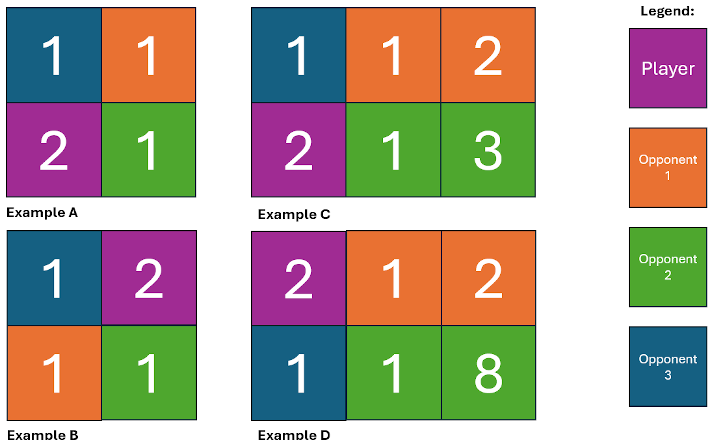

Construct a descriptor that returns the **same** state for board examples A & B.

In [14]:
#INPUT DATA EXAMPLE A
dice_A=np.ones((2,2))
dice_A[1,1]=2
players_A=np.zeros((2,2))
players_A[0,0]=1 #blue
players_A[0,1]=2 #orange
players_A[1,1]=3 #green

#INPUT DATA EXAMPLE B
dice_B=np.copy(dice_A)
players_B=np.copy(players_A)
players_B[0,1]=0 #purple
players_B[1,0]=2 #orange


# Build your descriptor here

def descriptor(dice, players):
    """INVARIABLE repr. that returns the same state for board """
    
   
    return(state)


## Assignment CD:
Construct a descriptor that returns the **same** state for board examples C & D. Do this by presenting the board from the **viewpoint** of you, the purple player, and that **you cannot look further than the first nearest neighbors**.

In [15]:
#INPUT DATA EXAMPLE C
dice_C=np.ones((2,3))
dice_C[0:1,0:1]=dice_A[0:1,0:1]
dice_C[0,2]=2
dice_C[1,2]=3
players_C=np.zeros((2,3))
players_C[0:2,0:2]=players_A[0:2,0:2]
players_C[0,2]=2 #orange
players_C[1,2]=3 #green


#INPUT DATA EXAMPLE B
dice_D=np.copy(dice_C)
dice_D[1,2]=8
dice_D[0,0]=2
dice_D[1,0]=1
players_D=np.copy(players_C)
players_D[0,0]=0 #purple
players_D[1,0]=1 #blue



def descriptor(dice, players):
    
    """Your code here"""
    
    return(state)

<hr>

# stuff to check tonight

Below is one relatively simple approach that mimics the “normalize‐and‐stack” idea from Part I but adapts it to a grid‐based DiceWars board. In this example we assume that:

-You want a representation that is invariant to global changes (like a reshuffling of colors) by first normalizing the player IDs.
-You “anchor” the state on your own (purple) territory. (We assume that after normalization the purple player is represented by 0.)
- You extract only the “local” information—that is, the dice and player data at the anchor and its immediate neighbors. (Here we use the four direct neighbors: up, right, down, and left.)
- You fix the order of the neighbors (e.g. in the order up, right, down, left) so that any board rotated globally or with a reshuffled color assignment but with the same local configuration yields the same descriptor.
- A possible implementation is as follows:

In [16]:
 ############ verify

import numpy as np

def descriptor_dicewars(dice, players):
    """
    Constructs a DiceWars board descriptor that is invariant to global transformations 
    (such as rotation of the whole board or reshuffling of opponent colors)
    by presenting the board from the viewpoint of the purple player (assumed to be represented by 0)
    and considering only first nearest neighbors (up, right, down, left).

    Parameters:
      dice: numpy.ndarray, the dice array (e.g. shape (rows, cols)) representing the dice count in each country.
      players: numpy.ndarray, the players array (same shape) representing which player controls each country.
    
    Returns:
      descriptor: a 1D numpy array containing the anchor (purple) cell's dice and normalized player ID,
                  followed by the dice and normalized player IDs for its neighbors in a fixed order.
                  If a neighbor is missing (edge of board), a default value is inserted.
    """
    # Step 1: Normalize players.
    unique_players = np.sort(np.unique(players))
    player_mapping = {p: i for i, p in enumerate(unique_players)}
    normalized_players = np.zeros_like(players, dtype=int)
    for orig, new in player_mapping.items():
        normalized_players[players == orig] = new

    # Step 2: Identify the anchor cell corresponding to "you" (the purple player).
    # We assume that purple is represented by 0.
    anchor_positions = np.argwhere(normalized_players == 0)
    if len(anchor_positions) == 0:
        raise ValueError("No purple player (value 0) found on board.")
    # Choose the first occurrence as the anchor.
    anchor = anchor_positions[0]  # anchor is an array like [row, col]

    # Step 3: Define the fixed neighbor directions (up, right, down, left).
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    neighbors = []
    rows, cols = players.shape
    for dr, dc in directions:
        r = anchor[0] + dr
        c = anchor[1] + dc
        if 0 <= r < rows and 0 <= c < cols:
            # Append the neighbor's dice and normalized player value.
            neighbors.append((dice[r, c], normalized_players[r, c]))
        else:
            # If the neighbor is outside the board, insert a default value.
            neighbors.append((0, -1))  # for example: dice 0 and player -1 as a flag.

    # Step 4: Build the descriptor by concatenating the anchor information and the neighbors in order.
    # For example, the descriptor is:
    # [anchor_dice, anchor_normalized_player, up_dice, up_player, right_dice, right_player, down_dice, down_player, left_dice, left_player]
    anchor_info = (dice[tuple(anchor)], normalized_players[tuple(anchor)])
    descriptor_array = np.array([anchor_info[0], anchor_info[1]] +
                                [val for pair in neighbors for val in pair])
    return descriptor_array

# Example usage with board example data:

# Board Example A:
dice_A = np.ones((2,2))
dice_A[1,1] = 2
players_A = np.zeros((2,2))
players_A[0,0] = 1  # blue
players_A[0,1] = 2  # orange
players_A[1,1] = 3  # green

# Board Example B:
dice_B = np.copy(dice_A)
players_B = np.copy(players_A)
players_B[0,1] = 0  # purple
players_B[1,0] = 2  # orange

desc_A = descriptor_dicewars(dice_A, players_A)
desc_B = descriptor_dicewars(dice_B, players_B)

print("Descriptor for board A:", desc_A)
print("Descriptor for board B:", desc_B)


Descriptor for board A: [ 1.  0.  1.  1.  2.  3.  0. -1.  0. -1.]
Descriptor for board B: [ 1.  0.  0. -1.  0. -1.  2.  3.  1.  1.]


Explanation
Normalization:
We first map the players’ IDs to a canonical range by sorting the unique values and reassigning them. This step removes differences due solely to how the colors are labeled.

Anchor Identification:
We then look for cells with the normalized value 0 (our “purple” cell). That cell is our viewpoint. (If more than one purple cell exists, you could choose one by a specific rule or combine their information.)

Local Extraction:
For the fixed neighbor order (up, right, down, left), we extract the (dice, normalized player) information. If a neighbor does not exist (for edge cells), we insert default values so that the descriptor’s length is fixed.

Final Descriptor:
We combine the anchor’s information and the neighbors’ information into a one‐dimensional vector. This descriptor should be invariant to global rotations (since you always “anchor” on your own cell and use a fixed neighbor order) and color reshufflings (because of the normalization).

For Assignment CD (which asks for a descriptor that returns the same state for board examples C & D from the purple player’s viewpoint with only first nearest neighbors), you could follow a similar approach. You might, for example, extend the above function by first “reorienting” the board so that the anchor is at a fixed location (if needed) or by extracting a local patch around the purple cell using the same neighbor‐ordering strategy.

This approach is relatively simple and follows a similar “normalize–extract–stack” idea as the buckyball descriptor, but adapted to a grid board and local neighborhood. Adjust the details (such as the neighbor definition) as needed for your DiceWars game representation.

# Descriptor 2

Below is one straightforward implementation for the “other” descriptor (Assignment CD). In this version you “anchor” on your own cell—that is, the purple cell (assumed to be normalized to 0)—and then you only record the local information from its first‐nearest neighbors (in a fixed order: up, right, down, left). This local descriptor ignores the rest of the board, so even if global features (like dice counts far away) change, the descriptor remains the same.

Explanation
1. Normalization:
The function first reassigns player labels to a canonical set (0, 1, …). In both boards, the purple player should then be represented by 0 regardless of its original id.

2. Anchor Selection:
It finds the purple cell (where the normalized player value is 0) and uses its position as the anchor (your viewpoint).

3. Local Neighbors:
Only the immediate up, right, down, and left cells (if available) are considered. The information extracted for each neighbor is the dice count and the normalized player id. If a neighbor falls outside the board, default values are used.

4. Final Descriptor:
The descriptor is a fixed-length vector combining the anchor’s information and its neighbors in a fixed order. This descriptor is designed to be invariant to global rotations and reshufflings (since the view is always anchored on you, the purple cell, and the neighbors are taken in a fixed order).

This is a relatively simple yet effective way to capture local board state information from your own perspective, and it should yield the same descriptor for board examples that are equivalent from the purple player's viewpoint. Feel free to adjust the neighbor definition or default values as needed for your specific DiceWars game representation.


In [17]:
import numpy as np

def descriptor_dicewars_local(dice, players):
    """
    Constructs a local DiceWars board descriptor that returns the same state 
    for boards that are equivalent from the viewpoint of the purple player.
    The descriptor includes the dice count and normalized player id of the anchor
    cell (the purple cell) and its four first-nearest neighbors (up, right, down, left).
    
    Parameters:
      dice: numpy.ndarray of shape (rows, cols) representing dice counts.
      players: numpy.ndarray of shape (rows, cols) representing player ids.
      
    Returns:
      descriptor: a 1D numpy array with the form:
         [anchor_dice, anchor_player, up_dice, up_player, right_dice, right_player,
          down_dice, down_player, left_dice, left_player]
      If a neighbor does not exist (edge of the board), default values (0 for dice and -1 for player)
      are inserted.
    """
    # Step 1: Normalize players to remove arbitrary color assignments.
    unique_players = np.sort(np.unique(players))
    player_mapping = {p: i for i, p in enumerate(unique_players)}
    norm_players = np.zeros_like(players, dtype=int)
    for orig, new in player_mapping.items():
        norm_players[players == orig] = new

    # Step 2: Find the anchor cell: assume the purple player is normalized to 0.
    anchor_positions = np.argwhere(norm_players == 0)
    if anchor_positions.shape[0] == 0:
        raise ValueError("No purple player (value 0) found on board.")
    # Choose the first purple cell as the anchor.
    anchor = anchor_positions[0]

    # Step 3: Define the fixed neighbor directions: up, right, down, left.
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    neighbor_info = []
    rows, cols = dice.shape
    for dr, dc in directions:
        r = anchor[0] + dr
        c = anchor[1] + dc
        if 0 <= r < rows and 0 <= c < cols:
            neighbor_info.append((dice[r, c], norm_players[r, c]))
        else:
            neighbor_info.append((0, -1))  # default values for missing neighbors

    # Step 4: Build the descriptor by concatenating the anchor info with the neighbor info.
    anchor_info = (dice[anchor[0], anchor[1]], norm_players[anchor[0], anchor[1]])
    descriptor = np.array([anchor_info[0], anchor_info[1]] + [x for pair in neighbor_info for x in pair])
    return descriptor

# Example usage:
# Board Example C:
dice_C = np.ones((2, 3))
dice_C[0:1, 0:1] = 1   # could be any value; here using ones for most cells
dice_C[0,2] = 2
dice_C[1,2] = 3
players_C = np.zeros((2, 3))
players_C[0:2, 0:2] = np.array([[1,2],[2,3]])  # arbitrary values
players_C[0,2] = 2  # orange
players_C[1,2] = 3  # green

# Board Example D:
dice_D = np.copy(dice_C)
dice_D[1,2] = 8
dice_D[0,0] = 2
dice_D[1,0] = 1
players_D = np.copy(players_C)
players_D[0,0] = 0  # purple (our viewpoint)
players_D[1,0] = 1  # blue

desc_C = descriptor_dicewars_local(dice_C, players_C)
desc_D = descriptor_dicewars_local(dice_D, players_D)

print("Descriptor for board C:", desc_C)
print("Descriptor for board D:", desc_D)


Descriptor for board C: [ 1.  0.  0. -1.  1.  1.  1.  1.  0. -1.]
Descriptor for board D: [ 2.  0.  0. -1.  1.  2.  1.  1.  0. -1.]
